In [14]:
import pandas as pd
import statsmodels.api as sm
import platform
import matplotlib.pyplot as plt
import matplotlib as mpl

In [15]:
mpl.rcParams['axes.unicode_minus'] = False
current_os = platform.system()
if current_os == 'Windows':
    plt.rcParams["font.family"] = 'Malgun Gothic'
elif current_os == 'Darwin':
    plt.rcParams["font.family"] = 'AppleGothic'
else:
    plt.rcParams["font.family"] = 'NanumGothic'

In [23]:
data = pd.read_csv('../../data/school_health_preprocessed.csv')

sleep_time_mapping = {
    1.0: 5.5,   # 6시간 이내 평균 가정
    2.0: 6.5,   # 6~7시간 평균 가정
    3.0: 7.5,   # 7~8시간 평균 가정
    4.0: 8.5    # 8시간 이상 평균 가정
}

breakfast_mapping = {
    1: 4,  # 거의 꼭 먹음
    2: 3,  # 대체로 먹음
    3: 2,  # 대체로 안 먹음
    4: 1   # 거의 안 먹음
}

schools = ['초', '중', '고']
genders = ['남', '여']

groups = [(gender, school) for gender in genders for school in schools]

In [25]:
df_elem = data[['하루수면량', '아침식사', 'BMI', '성별', '학교급', '주3회이상운동']].dropna()
df_elem['수면시간_수치'] = df_elem['하루수면량'].map(sleep_time_mapping)
df_elem['아침식사_수치'] = df_elem['아침식사'].map(breakfast_mapping)

exercise_mapping_3times = {
    1.0: 1,  # 예
    2.0: 0   # 아니오
}
df_elem['운동여부_3회'] = df_elem['주3회이상운동'].map(exercise_mapping_3times)

df_elem['학교급'] = df_elem['학교급'].astype(str)
df_elem['성별'] = df_elem['성별'].astype(str)

df_mid_high = data[['하루수면량', '아침식사', 'BMI', '성별', '학교급', '하루30분이상운동']].dropna()
df_mid_high['수면시간_수치'] = df_mid_high['하루수면량'].map(sleep_time_mapping)
df_mid_high['아침식사_수치'] = df_mid_high['아침식사'].map(breakfast_mapping)

exercise_mapping_30min = {
    1.0: 1,
    2.0: 2,
    3.0: 3,
    4.0: 4
}
df_mid_high['운동빈도_30분'] = df_mid_high['하루30분이상운동'].map(exercise_mapping_30min)

df_mid_high['학교급'] = df_mid_high['학교급'].astype(str)
df_mid_high['성별'] = df_mid_high['성별'].astype(str)

In [26]:
def perform_regression(group_data, group_name, vars):
    X = group_data[vars]
    X = sm.add_constant(X)
    y = group_data['BMI']
    
    if len(group_data) < 10:
        print(f"=== {group_name} 그룹의 데이터 수가 부족합니다: {len(group_data)}개 ===\n")
        return None
    
    model = sm.OLS(y, X).fit()
    
    print(f"=== {group_name} 그룹 회귀 결과 ===")
    print(model.summary())
    print("\n")
    return model

In [27]:
regression_results = {}

# 초등학생 그룹 분석 (주3회이상운동 사용)
for gender in genders:
    group_name = f"초{gender}"
    group_data = df_elem[(df_elem['학교급'] == '초') & (df_elem['성별'] == gender)]
    vars_independent = ['수면시간_수치', '아침식사_수치', '운동여부_3회']
    model = perform_regression(group_data, group_name, vars_independent)
    if model is not None:
        regression_results[group_name] = model

# 중·고등학생 그룹 분석 (하루30분이상운동 사용)
for school in ['중', '고']:
    for gender in genders:
        group_name = f"{school}{gender}"
        group_data = df_mid_high[(df_mid_high['학교급'] == school) & (df_mid_high['성별'] == gender)]
        vars_independent = ['수면시간_수치', '아침식사_수치', '운동빈도_30분']
        model = perform_regression(group_data, group_name, vars_independent)
        if model is not None:
            regression_results[group_name] = model

=== 초남 그룹 회귀 결과 ===
                            OLS Regression Results                            
Dep. Variable:                    BMI   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     130.8
Date:                Wed, 11 Dec 2024   Prob (F-statistic):           9.35e-84
Time:                        03:06:21   Log-Likelihood:                -46334.
No. Observations:               16751   AIC:                         9.268e+04
Df Residuals:                   16747   BIC:                         9.271e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.3947      0.322

In [37]:
coefficients_sleep = {'그룹': [], '회귀계수': []}
coefficients_breakfast = {'그룹': [], '회귀계수': []}
coefficients_exercise = {'그룹': [], '회귀계수': []}

for group, model in regression_results.items():
    params = model.params
    if '운동여부_3회' in params.index:
        sleep_coef = params['수면시간_수치']
        breakfast_coef = params['아침식사_수치']
        exercise_coef = params['운동여부_3회']
    else:
        sleep_coef = params['수면시간_수치']
        breakfast_coef = params['아침식사_수치']
        exercise_coef = params['운동빈도_30분']
    
    coefficients_sleep['그룹'].append(group)
    coefficients_sleep['회귀계수'].append(sleep_coef)

    coefficients_breakfast['그룹'].append(group)
    coefficients_breakfast['회귀계수'].append(breakfast_coef)

    coefficients_exercise['그룹'].append(group)
    coefficients_exercise['회귀계수'].append(exercise_coef)

In [33]:
coeff_sleep_df = pd.DataFrame(coefficients_sleep)
coeff_breakfast_df = pd.DataFrame(coefficients_breakfast)
coeff_exercise_df = pd.DataFrame(coefficients_exercise)

def plot_bar_with_values(df, title, ylabel, color):
    plt.figure(figsize=(10,6))
    bars = plt.bar(df['그룹'], df['회귀계수'], color=color)
    plt.axhline(0, color='grey', linewidth=1)
    plt.title(title)
    plt.xlabel('그룹')
    plt.ylabel(ylabel)
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2,
                 height,
                 f"{height:.3f}",
                 ha='center', va='bottom', fontsize=9)
    plt.show()

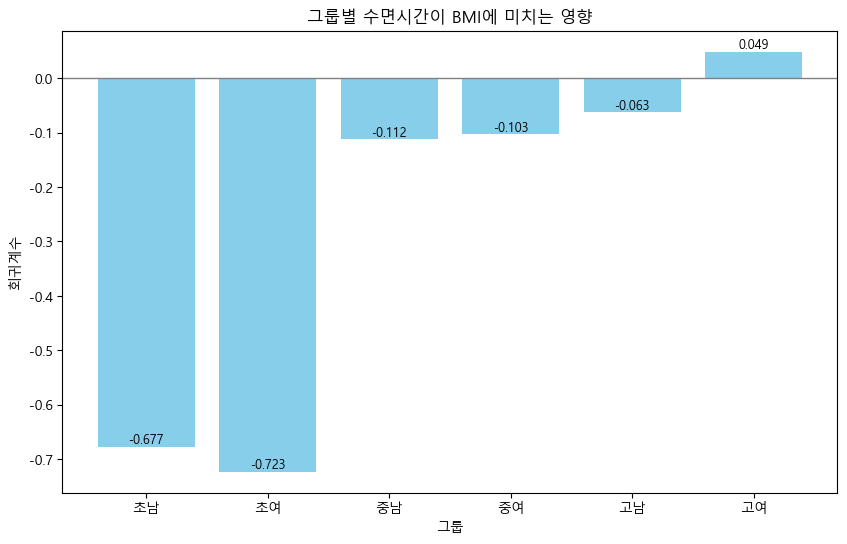

In [38]:
plot_bar_with_values(coeff_sleep_df, '그룹별 수면시간이 BMI에 미치는 영향', '회귀계수', 'skyblue')

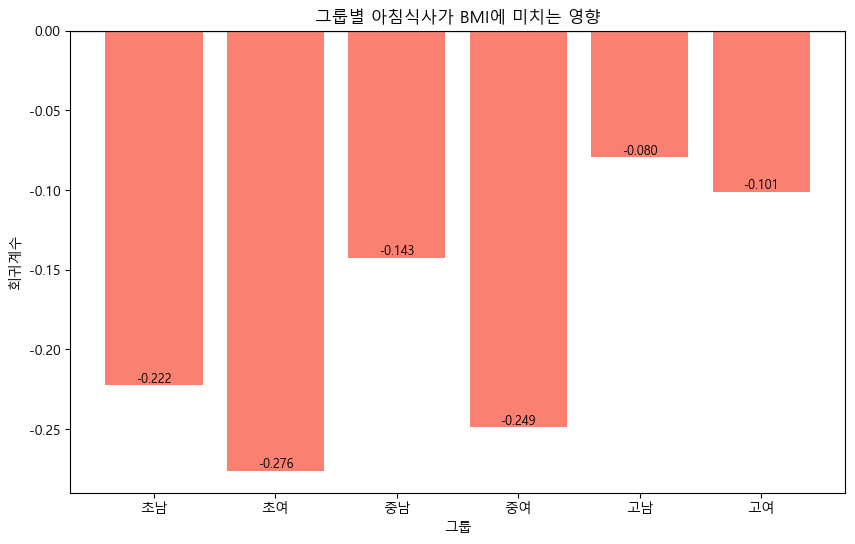

In [39]:
plot_bar_with_values(coeff_breakfast_df, '그룹별 아침식사가 BMI에 미치는 영향', '회귀계수', 'salmon')

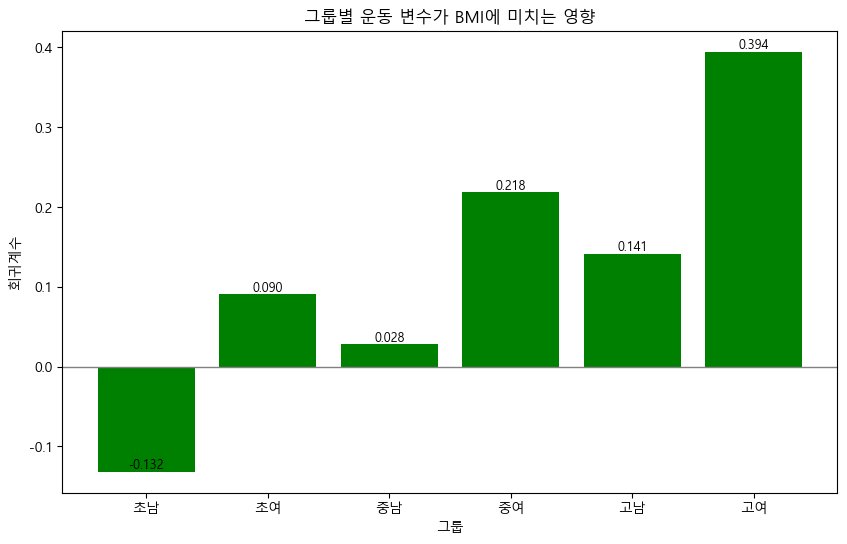

In [40]:
plot_bar_with_values(coeff_exercise_df, '그룹별 운동 변수가 BMI에 미치는 영향', '회귀계수', 'green')